In [1]:
!cd

D:\Ansys Simulations\Project\2D\preprocessing


## Formatting
In this notebook, the objective is to explore and develop a way to transformed the scaled data into a relevant data format/file/shape that can be used for a 2d convolutional neural network. Ideally, what is desired is a file that can store tensors as spatial data and that can be used by a ConvNet.
After some research, the conclusion is that the best way to do this is to format them as a 4D numpy array and saved as a .npy file so that they can be later quickly read into memory.

In [1]:
## Imports
import numpy as np
import matplotlib.pyplot as plt
from PREPROCESSING_splitting import get_number
import PREPROCESSING_scaling as scale
from pathlib import Path
import pandas as pd
import os, sys

splitting functions imported
scaling functions imported


In [203]:
## 3d visualization import
%gui qt
from mayavi import mlab
mlab.init_notebook('png')

Notebook initialized with png backend.


In [7]:
## load in and scale  a sample

data_folder_path =  Path('D:/Ansys Simulations/Project/2D/data') 

# get data
raw_input_data, raw_output_data = scale.get_sample_dfs(data_folder_path, 26)

max_force, max_disp = scale.get_max_disp_force(data_folder_path)

scaled_input_data = scale.scale_dataframe(raw_input_data, max_force, max_disp)
with pd.option_context("display.max_rows", None):
    display(scaled_input_data.iloc[170:189,:])

UPDATED MAX 	 sample #1 	 force: 0.00 	 displacement: 0.002053 
UPDATED MAX 	 sample #10 	 force: 152.79 	 displacement: 0.003020 
UPDATED MAX 	 sample #100 	 force: 152.79 	 displacement: 0.019382 
UPDATED MAX 	 sample #101 	 force: 242.87 	 displacement: 0.019382 
UPDATED MAX 	 sample #11 	 force: 287.27 	 displacement: 0.019382 
UPDATED MAX 	 sample #55 	 force: 295.32 	 displacement: 0.019382 


,node_number,named_selection,x_loc,y_loc,z_loc,x_disp,y_disp,z_disp,x_force,y_force,z_force
170,171,-1,0.180590,0.242730,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
171,172,-1,0.138780,0.205680,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
172,173,-1,0.068634,0.123060,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
173,174,-1,0.054411,0.084662,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
174,175,-1,0.024266,0.072970,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
175,176,2,0.328590,0.694900,0.0,-0.050859,-0.107693,0.0,0.0,0.0,0.0
176,177,1,0.189800,0.568730,0.0,0.031275,-0.014854,0.0,0.0,0.0,0.0
177,178,1,0.127090,0.604280,0.0,0.031275,-0.014854,0.0,0.0,0.0,0.0
178,179,2,0.245740,0.732520,0.0,-0.050859,-0.107693,0.0,0.0,0.0,0.0
179,180,2,0.269410,0.625380,0.0,-0.050859,-0.107693,0.0,0.0,0.0,0.0


To run the convolutional layer on the data, the data has to be converted from the positions table into an object that represents the element's positions in a way that a convolutional kernel is able to understand positional relationships. Looking at the 3D data files generated, there seem to be about 10000 nodes on each of those samples (although the intent is to decrease it later to speed up sample creation). With this in mind, and knowing that most of the samples have a relatively similar volume, choosing a size of 32x32x32 entries in which to split the data is an arbitrary choice which seems to lead to a good balance of nodal specificity, averaging and processing time for the network. 

The fourth dimension's size depends on the amount of features. For directional data such as displacement and forces, there are three components per type. On top of that, one more feature is created which is the "existence" feature, which encodes whether a certain "volume" in space contains material from the element or not, varying from 0 (no material) to 1 (filled with  material). It is only different than 1 or 0 on the edges/faces of the element. 

In [8]:
## Create an empty numpy array with the correct dimensions
def create_array(dimensionality, features, resolution = 32):
    ## returns an array of zeros for the correct type of model specified with the dimensionality and the features
    positional_shape = [resolution]*dimensionality
    shape = positional_shape + [features]
    array = np.zeros(shape)
    return array

In [9]:
print(create_array(3,6, 35).shape)
print(create_array(2,4).shape)

(35, 35, 35, 6)
(32, 32, 4)


To correctly distribute the data inside of the tensor, it is necessary to get the maximum positional dimensions of the dataset so that every sample actually fits inside of the tensor

In [10]:
## Create function to run through all data and get max values of dimensions
def get_max_dimensions(samples_folder_path):
    ## iterates through all data to get the max dimensions
    samples = scale.sample_iterator(samples_folder_path)
    
    max_x = 0
    max_y = 0
    max_z = 0
    
    for sample in samples:
        sample_number, input_data, output_data = sample
        #print(samples)
        
        ## run through all data
        # first absolute, then max in the columns 
        updated = False
        max_x_temp, max_y_temp, max_z_temp = input_data.loc[:,['x_loc','y_loc','z_loc']].abs().max()
        
        if max_x_temp > max_x:
            range_x = [input_data.loc[:,['x_loc']].max().item(), input_data.loc[:,['x_loc']].min().item()]
            max_x = abs(range_x[0] - range_x[1])
            updated = True
            
        if max_y_temp > max_y:
            range_y = [input_data.loc[:,['y_loc']].max().item(), input_data.loc[:,['y_loc']].min().item()]
            max_y = abs(range_y[0] - range_y[1])
            updated = True
            
        if max_z_temp > max_z:
            range_z = [input_data.loc[:,['z_loc']].max().item(), input_data.loc[:,['z_loc']].min().item()]
            max_z = abs(range_z[0] - range_z[1])
            updated = True
            
        if updated:
            print(f'UPDATED MAX \t sample #{sample_number} \t x: {max_x:.4f} \t y: {max_y:.4f} \t z: {max_z:.4f}')
            
    return max_x, max_y, max_z

In [11]:
max_dims = get_max_dimensions(data_folder_path)

UPDATED MAX 	 sample #1 	 x: 0.9692 	 y: 1.1906 	 z: 0.0000
UPDATED MAX 	 sample #10 	 x: 1.0849 	 y: 1.1906 	 z: 0.0000
UPDATED MAX 	 sample #100 	 x: 1.4374 	 y: 1.3295 	 z: 0.0000
UPDATED MAX 	 sample #101 	 x: 1.4374 	 y: 1.4031 	 z: 0.0000
UPDATED MAX 	 sample #102 	 x: 1.6833 	 y: 1.4031 	 z: 0.0000
UPDATED MAX 	 sample #12 	 x: 1.7286 	 y: 1.4031 	 z: 0.0000
UPDATED MAX 	 sample #50 	 x: 1.7286 	 y: 1.4830 	 z: 0.0000


In [12]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [13]:
#create function that creates an element size for the resolution
def get_element_size(samples_folder_path, resolution = 32):
    ## runs through all samples to get the element size based on the resolution
    with HiddenPrints():
        max_x, max_y, max_z = get_max_dimensions(samples_folder_path)
    
    largest_dim = max([max_x, max_y, max_z])
   
    element_size = largest_dim/resolution
    
    return element_size

In [14]:
element_size = get_element_size(data_folder_path)

I just realized that the scaling step performed earlier on the pandas dataframe is of no use since there is no guarantee that two nodes aren't going to fall in the same element, and thus the data must be re-scaled after it has been fitted into the new format, as the maximums will change. This will be implemented later, and the previous scaling function will be considered deprecated.

In [177]:
## create function that takes  the element size and a tensor index and uses it to get
## node indices that match that location from a sample.
def get_dataframe_indices(element_size, sample_df, x, y, z=0, Is_2D=True):
    ## create function that takes  the element size and a tensor index and uses it to get
    ## dataframe indices that match that spatial location from a sample
    
    ## gets range of values
    x_range = [x*element_size, (x+1)*element_size]
    y_range = [y*element_size, (y+1)*element_size]    
     
    #print((sample_df['x_loc']))
    x_condition = sample_df['x_loc'].between(x_range[0], x_range[1])
    y_condition = sample_df['y_loc'].between(y_range[0], y_range[1])
    
    if Is_2D:
        indices =  (x_condition.values & y_condition.values)
    
    if not(Is_2D):
        z_range = [z*element_size, (z+1)*element_size]
        z_condition = sample_df['z_loc'].between(z_range[0], z_range[1])
        indices =  (x_condition.values & y_condition.values &z_condition.values) 
    
    return np.where(indices)[0]

In [179]:
import time
tic = time.time()
get_dataframe_indices(element_size, raw_input_data, 0,4)
toc = time.time()
print(tic-toc)
print(get_dataframe_indices(element_size, raw_input_data, 0,4))

-0.0009658336639404297
[137 453 455 511]


To be able to assign the correct position for the element inside of the tensor, the quadrant(2d)/octant(3d) it was created in must be determined. If the element wasn't created in a discernible quadrant in mind, it is still necessary to assign a equivalent one to it to position it inside of the tensor

In [180]:
## create function to choose equivalent octant 
def get_quadrant(sample_df):
    ## gets the sample's main octant by returning a 3 component vector that points to that octant. 
    ## a zero in the last component means that it is a 2d problem and thus it points to a 2d 
    ## quadrant
    
    #gets the maximum absolute values
    max_x_abs, max_y_abs, max_z_abs = sample_df.loc[:,['x_loc','y_loc','z_loc']].abs().max()
    
    ## checks if 2d or 3d problem
    Is_2D = True
    if max_z_abs != 0:
        Is_2D = False
    ## get index of the maximum absolute values
    x_index = np.where(sample_df.loc[:,['x_loc']].abs().values.squeeze() == [max_x_abs])
    y_index = np.where(sample_df.loc[:,['y_loc']].abs().values.squeeze() == [max_y_abs])
    if not(Is_2D):
        z_index = np.where(sample_df.loc[:,['z_loc']].abs().values.squeeze() == [max_z_abs])
    else:
        z_index = [[0]]
        
    ## gets the value in that index
    values = np.array([sample_df.loc[x_index[0],['x_loc']].values[0][0],
                      sample_df.loc[y_index[0],['y_loc']].values[0][0],
                      sample_df.loc[z_index[0],['z_loc']].values[0][0]])
    
    ## create array with information about the octant via a vector
    octant = np.zeros(3)
    octant[0:2] =  values[0:2]/abs(values[0:2])
    if not(Is_2D):
        octant[2] = values[2]/abs(values[2])
    
    return octant

In [181]:
get_quadrant(raw_input_data)

array([1., 1., 0.])

Knowing in which octant the element was created in, it can be translated to the correct position. The idea is that, depending on the octant, the element was created in, it is going to be 'pressed against' a certain corner of the tensor. It is going to be translated to touch the "edges" of the tensor that correnspond to the planes it would be closest on the coordinate axis system it was created. So if it was created on the $(-x,-y,z)$ octant, for instance, it would be pressed the bottom, right, front corner of the cube shaped tensor. Illustratively, for some of the octants:
$$
(x,  y  ,z) \rightarrow (left, back, bottom) : stays \space in \space place
$$
$$
(-x, y, -z) \rightarrow (right, back, top) : moves \space right \space and\space up
$$
$$
(x,  y, -z) \rightarrow (left, back, top) : moves\space up
$$

In [182]:
## find a dataset in a different octant for testing of next part
raw_input_data_octant, _ = scale.get_sample_dfs(data_folder_path, 1)
get_quadrant(raw_input_data_octant)

array([-1.,  1.,  0.])

In [183]:
## create function to translate the dataframe
def  translate_df(sample_df, max_dimensions):
    ## gets a dataframe and translates the values to the correct position to place in the tensor
    
    octant = get_quadrant(sample_df)
    
    df_temp = sample_df.copy()
    largest_dim = max(*max_dimensions)
    
    ## general translation: translates according to the overall octant
    for i, direction in enumerate(octant):
        direction_is_negative = direction < 0
        if direction_is_negative:
            if i == 0:
                df_temp.loc[:,['x_loc']] = df_temp.loc[:,['x_loc']] + largest_dim
            if i == 1:
                df_temp.loc[:,['y_loc']] = df_temp.loc[:,['y_loc']] + largest_dim
            if i == 2:
                df_temp.loc[:,['z_loc']] = df_temp.loc[:,['z_loc']] + largest_dim
        
        ## minor translation: if some parts of the element are still "sticking out"
        ## after the general translation, move it just enough to ensure that it fits inside
        if not(direction_is_negative):
            min_val = df_temp.loc[:,['x_loc','y_loc', 'z_loc']].iloc[:, i].min()
            if min_val < 0.0:
                if i == 0:
                    df_temp.loc[:,['x_loc']] = df_temp.loc[:,['x_loc']] + abs(min_val)
                if i == 1:
                    df_temp.loc[:,['y_loc']] = df_temp.loc[:,['y_loc']] + abs(min_val)
                if i == 2:
                    df_temp.loc[:,['z_loc']] = df_temp.loc[:,['z_loc']] + abs(min_val)
    
    return df_temp
    

In [184]:
translated_input = translate_df(raw_input_data_octant, max_dims)
translated_input

,node_number,named_selection,x_loc,y_loc,z_loc,x_disp,y_disp,z_disp,x_force,y_force,z_force
0,1,2,1.28412,1.19060,0.0,0.001100,-0.001333,0.0,0.0,0.0,0.0
1,2,-1,1.72860,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,3,2,1.29647,1.15750,0.0,0.001100,-0.001333,0.0,0.0,0.0,0.0
3,4,2,1.30881,1.12450,0.0,0.001100,-0.001333,0.0,0.0,0.0,0.0
4,5,3,1.32116,1.09140,0.0,0.000103,-0.000168,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
762,763,-1,0.91355,0.25423,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
763,764,-1,0.94754,0.27206,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
764,765,-1,1.36060,0.14624,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
765,766,-1,1.06133,0.47701,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


Now,  having translated the element into the part of the space we need for the tensor, we need to perform the data collection into the features of the tensor

In [192]:
## Create a function that creates a hard map of where the element is
def get_material_map_hard(translated_sample_df, element_size, dimensionality=2):
    ## gets the sample df and returns a tensor with 1 where nodes are found,
    ## and 0 where no nodes are found
    
    ##Initialize an array for this feature
    array = create_array(dimensionality, features=1, resolution = 32)

    arr_iterator = np.nditer(array, flags=['multi_index'])
    for location in arr_iterator:

        x = arr_iterator.multi_index[0]
        y = arr_iterator.multi_index[1]
        z = arr_iterator.multi_index[2]
        
        if get_dataframe_indices(element_size, translated_sample_df, x, y, z).size > 0: ## empty list returns False
            array[x,y,z] = 1.
    return array

In [193]:
tic = time.time()
get_material_map_hard(translated_input, element_size, dimensionality=2)
toc = time.time()
print(toc-tic)

0.6872062683105469


(32, 32, 2)



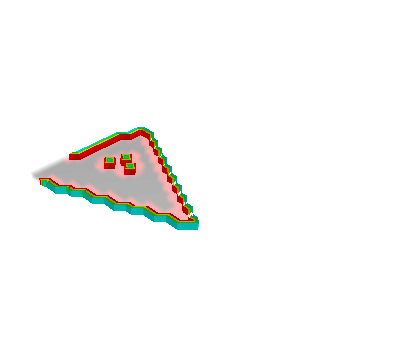

In [204]:
hard_map_array = get_material_map_hard(translated_input, element_size, dimensionality=2)
def plot_3d(sample_array):
    mlab.clf()
    if len(sample_array.shape)==3:
        sample_array = np.concatenate((sample_array, sample_array), axis=2)
        #sample_array = np.concatenate((sample_array, sample_array), axis=2)
        print(sample_array.shape)
    
    s = sample_array #np.random.rand(20, 20,2) #
    mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=None, engine=None, size=(400, 350))
    volume = mlab.pipeline.volume(mlab.pipeline.scalar_field(s), vmin=0.2, vmax=0.8)
    mlab.contour3d(s)
    return volume
plot_3d(hard_map_array)

In the image above, the shaded part represents the points where nodes were detected. The colourful edge is a contour of 'same value' surfaces, which is used to demonstrate where there is sharp transition in values. As can be seen,  it works roughly as expected, however the edges are jagged and some spots in the center where the nodes are very far apart, the tensor actually sees no nodes and receive a zero value. To correct this, it can be filtered with a convolutional kernel to create an average value for every point, smoothing out the edges and filling the internal elements that are empy.

In [ ]:
## create a function that creates a fuzzy map of where the element is

In [ ]:
## create a function that gets a sample dataframe and transforms it into an array